In [18]:
import torch
import torch.nn as nn

import numpy as np
from utils.vmf_batch import vMF
from utils.sampling_utils import _get_cut_off_index_by_path_angle, _fill_with_infty, _get_cut_off_index_by_threshold
from models import SeqEncoder, SeqDecoder, Seq2SeqDataSet, Seq2Seq_VAE, PoolingClassifier, init_weights

## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
def decode_z(model,z, init_state=torch.Tensor([[0,0,0]]), max_trg_len=16):
    
    with torch.no_grad():

        # z = [batch size, LATENT DIM]
        batch_size, lat_dim = z.shape
        
        #first input to the decoder is the first coordinate
        input = init_state.repeat(batch_size,1).to(model.device)
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_trg_len, batch_size, model.decoder.output_dim).to(model.device)
        
        hidden, cell = model._get_decoder_states(z, batch_size=batch_size)
        for t in range(1, max_trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = model.decoder(input, hidden, cell)
        
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #get the highest predicted token from our predictions
            input = output
                
            # stop the decoding when only the padding element is predicted
            if input.allclose(init_state.to(model.device), atol=0.0001):
                break
    
    return outputs


def sample_rws(vmf, mu, max_trg_len=16, n_samples=4, min_angle=np.pi/3):
    
    batch_size, latent_dim = mu.shape
    decoded_rws = []
    for k in range(n_samples):
        tup, kld, sampled_vecs = vmf.build_bow_rep(mu, n_sample=5)

        z = sampled_vecs.mean(dim=0)

        decoded_z = decode_z(model, z, max_trg_len=max_trg_len).cpu()
        seq_lengths = _get_cut_off_index_by_path_angle(decoded_z, min_angle=min_angle)
        
        decoded_z = _fill_with_infty(decoded_z, seq_lengths)
        decoded_z = decoded_z.permute(1,0,2).unsqueeze(0)
        decoded_rws.append(decoded_z)
        
    return torch.cat(decoded_rws, dim=0)

In [33]:
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# parameter
INPUT_DIM = 3                     # size of each input
EMBED_DIM = 32                    # Size of the embedding (to prevent cheating)
HIDDEN_DIM = 32
LATENT_DIM = 32                  # latent vector dimension
KAPPA = 500
NUM_LAYERS = 2
DROPOUT = .1
NUM_CLASSES = 14

SEED = 17

# model
enc = SeqEncoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = SeqDecoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dist = vMF(LATENT_DIM, kappa=KAPPA)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)

state_dict = torch.load('./models/classification_analysis/k500/vae_frac_1.00_run1.pt')
# state_dict = torch.load('./models/Farrow/scratch/soma_centered/vae_frac0.0_scaled_best_run1.pt')
model.load_state_dict(state_dict['model_state_dict'])


KLD: 45.709938049316406


<All keys matched successfully>

In [34]:
import pickle
with open('./data/toy_data/3_populations/iterator/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)

In [35]:
SEED = 17
# get data
np.random.seed(SEED)
torch.random.manual_seed(SEED)
src_data, trg_data, seq_len, indices, labels = list(val_iterator)[0]
rw_i = np.round(trg_data, 2)

N, n_walks, walk_length, f = src_data.shape
rw_i = _fill_with_infty(rw_i.permute(2,0,1,3).reshape(walk_length, -1, f), seq_len.reshape(-1))

rw_i = rw_i.reshape(walk_length,N,n_walks,f).permute(1,2,0,3)

In [ ]:
model.eval()
with torch.no_grad():
    bs, n_walks, walk_length, input_dim = src_data.shape
    src = src_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    # src = [walk length , bs * n_walks, input_dim]
    trg = trg_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    seq_len = seq_len.view(-1).to(device)
    output = model(src, seq_len, trg, 0)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
vmf_10 = vMF(LATENT_DIM, kappa=10)
vmf_100 = vMF(LATENT_DIM, kappa=100)
vmf_500 = vMF(LATENT_DIM, kappa=500)


In [ ]:

sns.set_context('notebook')
n_idx_ = 0
w_idx_ = 101
plt.plot(rw_i[n_idx_][w_idx_,:,0].T, rw_i[n_idx_][w_idx_,:,1].T)

In [ ]:
sns.reset_orig()

In [ ]:
# sample several times from mu and look at the decoding, what changes?
torch.manual_seed(17)
sns.set(font_scale=1.5)
min_angle=np.pi
thresh = 2
vec_colors = np.array(sns.color_palette('Greys_r', n_colors=4))[1]
fig, axes = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
axes = axes.flatten()
for v, vmf in enumerate([vmf_10, vmf_100,vmf_500]):


    # get latent representation of one random walk
    mu = model.h[n_idx_*n_walks + w_idx_].cpu().reshape(1,-1)

    axes[v].plot(rw_i[n_idx_][w_idx_,:,0].T, rw_i[n_idx_][w_idx_,:,1].T, 
             c='k', marker='o', linewidth=3, zorder=10,
             label='Original walk')

    sns.despine()


    # sample X latent representations from encoded mu
    N_samp = 5
    tup, kld, sampled_vecs = vmf.build_bow_rep(mu.to(device), n_sample=N_samp)

    
    decoded_z = decode_z(model, sampled_vecs.squeeze())
    decoded_z = _fill_with_infty(decoded_z, _get_cut_off_index_by_path_angle(decoded_z, np.pi/2)).cpu()
    for k in range(N_samp): 
        s = sampled_vecs[k]
        axes[v].plot(decoded_z[:,k,0], decoded_z[:,k,1],
                 marker='o', c=vec_colors, linewidth=2, markersize=5,
                 label='Decoded $z_i$')

handles, labels = axes[0].get_legend_handles_labels()
axes[2].legend(handles[:2], labels[:2],bbox_to_anchor=(1.,1.1), frameon=False)
# plt.savefig('./pics/ICML/resubmission/Fig5/sampled_walks.svg', format='svg')

In [10]:
sns.set_context('paper')

In [11]:
sns.reset_orig()

In [ ]:
# investigate the walks more thoroughly
# create artificial walks 

In [8]:
def sample_rws(vmf, mu, max_trg_len=16, n_samples=4, min_angle=np.pi/3):
    
    batch_size, latent_dim = mu.shape
    decoded_rws = []
    for k in range(n_samples):
        tup, kld, sampled_vecs = vmf.build_bow_rep(mu, n_sample=5)

        z = sampled_vecs.mean(dim=0)

        decoded_z = decode_z(model, z, max_trg_len=max_trg_len).cpu()
        seq_lengths = _get_cut_off_index_by_path_angle(decoded_z, min_angle=min_angle)
        
        decoded_z = _fill_with_infty(decoded_z, seq_lengths)
        decoded_z = decoded_z.permute(1,0,2).unsqueeze(0)
        decoded_rws.append(decoded_z)
        
    return torch.cat(decoded_rws, dim=0)


In [9]:
straight_line = np.array([[0,0,0],[1,1,0], [2,2,0], [3,3,0], [4,4,0], [5,5,0], [6,6,0]])
kink = np.array([[0,0,0], [0,2,0], [0,4,0], [0,6,0], [2,6,0], [4,6,0], [6,6,0]])
zigzag = np.array([[0,0,0], [0,2,0], [2,0,0], [2,4,0], [4,2,0], [4,6,0], [6,4,0], [6,6,0]])

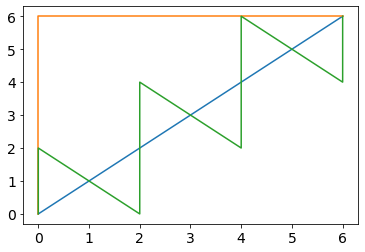

In [10]:
plt.plot(straight_line[:,0], straight_line[:,1])
plt.plot(kink[:,0], kink[:,1])
plt.plot(zigzag[:,0], zigzag[:,1])

In [13]:
from training_utils import create_Seq2SeqDataset

In [11]:
test_walks = np.ones((9,1,16,3))*-np.infty
test_walks[0,0,:7] = straight_line
test_walks[1,0,:7] = straight_line/3
test_walks[2,0,:7] = straight_line/6

test_walks[3,0,:7] = kink
test_walks[4,0,:7] = kink/3
test_walks[5,0,:7] = kink/6

test_walks[6,0,:8] = zigzag
test_walks[7,0,:8] = zigzag/3
test_walks[8,0,:8] = zigzag/6

In [14]:
test_ds = create_Seq2SeqDataset(torch.Tensor(test_walks))
iterator = torch.utils.data.DataLoader(test_ds, batch_size=100)
src_data, trg_data, seq_len, indices = list(iterator)[0]

model.eval()
with torch.no_grad():
    bs, n_walks, walk_length, input_dim = src_data.shape
    src = src_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    # src = [walk length , bs * n_walks, input_dim]
    trg = trg_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    seq_len = seq_len.view(-1).to(device)
    output = model(src, seq_len, trg, 0)

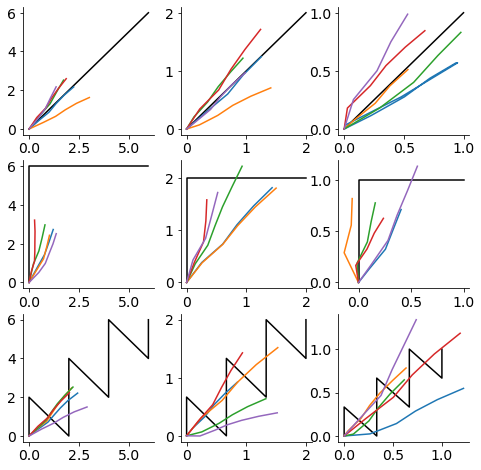

In [22]:
fig, axes = plt.subplots(3,3, figsize=(8,8))
axes = axes.flatten()
for ix in range(9):
    mus = model.h[ix].reshape(1,-1)
    mus /= mus.norm()
    decoded_rws = sample_rws(vmf_100, mus, n_samples=5, max_trg_len=walk_length, min_angle=np.pi/1.8).squeeze()

    axes[ix].plot(test_walks[ix,0,:,0], test_walks[ix,0,:,1], c='k')
    axes[ix].plot(decoded_rws[:,:,0].T, decoded_rws[:,:,1].T)
sns.despine()